# TP4 - Implémentation des modèles de CF avec descente de gradient stochastique

* Modèle classique L2
* Modèle avec biais utilisateur et items
* Modèle avec Biais temporel
* Evaluation des modèles sur la base MovieLens

Movie Lens : http://files.grouplens.org/datasets/movielens/ml-100k.zip (fichier u.data)

# Lecture des données

Les données se trouve dans des fichiers CSV, que nous allons lire dans une liste de liste afin de faciliter leurs exploitation dans Python.
Seul les trois première colonne du fichier <i>u.data</i> nous interesse ( Nous n'avons pas besoins du <i>timestamp</i>).

In [183]:
import numpy as np
import csv
import time
import pickle as pkl
import scipy.stats

datapath = 'ml-100k/'
filename = "u.data"

def read_lines(filename):
    return list(row[0:3] for row in list(csv.reader( open(filename, 'rb'), delimiter='\t')) )

# Représentation des données
Nous allons indexer les ratings sous deux formes afin de réaliser ce TME:
    - Ratings en fonction de user_id,item_id
    - Ratings en fonction de item_id,user_id

In [184]:
def user_indexed(data):
    user_index = {}
    for [user_id, item_id, rating] in data:
        if user_id not in user_index:
            user_index[user_id] = {item_id: rating}
        else:
            user_index[user_id][item_id] = rating
    return user_index


def item_indexed(data):
    item_index = {}
    for [user_id, item_id, rating] in data:
        if item_id not in item_index:
            item_index[item_id] = {user_id: rating}
        else:
            item_index[item_id][user_id] = rating
    return item_index

# Données d'évaluation
Nous allons séparer les données en données d'entraintement et de test avec une certain proportion afin de pouvoir tester les modèles que nous allons implémenter.

In [185]:
def split_data(data, train_prop):
    p = np.random.permutation(data)
    train_size = round(train_prop * len(p) )
    return p[:train_size], p[train_size:] #train, test

# Factorisation de matrices
La factorisation matriciel dans notre cas est le fait de représenter les valeurs de la matrice des ratings $X(N\times M)$ sous la forme d'un produit de la matice des utilisateurs $P(F\times N)$ et de la matrice des items $Q(F\times M)$

Le modèle basé sur la factorisation matriciel tente de minimiser la fonction $C(P,Q)$ tel que:
$C(P,Q) = \left \| X-PQ \right \|^2 + Cost(P,Q)$, ou $Cost(P,Q)$ sont des contraintes sur $P$ et $Q$

La baseline dans ce genre de modèles et de faire de la prédiction en faisant juste la moyenne des notes d'un utilisateur, ou bien la moyenne des notes sur un item (film)

In [186]:
class BaselineUser():
    def fit(self, user_index):
        self.model = {}
        for user in user_index.keys():
            self.model[user] = 0
            for item in user_index[user].keys():
                self.model[user] += int(user_index[user][item])
            self.model[user] /= len( user_index[user] )
    def predict(self, lines):
        self.pred = [self.model[u] for [u, _, _] in lines]
        return self.pred
    
    def error(self, test):
        return (( np.array(self.pred) - test ) ** 2).mean()

    
class BaselineItem():
    def fit(self,item_index):
        self.model = {}
        for item in item_index.keys():
            self.model[item] = 0
            for user in item_index[item].keys():
                self.model[item] += int(item_index[item][user])
            self.model[item] /= len( item_index[item] )
    def predict(self, lines):
        self.pred = [self.model[i] for [_, i, _] in lines]
        return self.pred
    
    def error(self, test):
        return (( np.array(self.pred) - test ) ** 2).mean()


# Factorisation Matriciel

In [187]:

class MatrixFactorization():
    def __init__(self,f, iter=100, e=0.001, lmbda=0.2):
        self.f = f
        self.iter = iter
        self.e = e
        self.lmbda = lmbda
        
        
        self.p = {}
        self.q = {}
        self.bu = {}
        self.bi = {}
        
        self.loss_history = []
        self.pred = []

    def fit(self, data):
        t_total = 0
        for it in xrange(self.iter):
            loss = 0
            t = time.time()
            data_perm = np.random.permutation(data) # stochastique
            for j in xrange(len(data_perm)):
                
                u = data_perm[j][0]
                i = data_perm[j][1]
                r_ui = data_perm[j][2]
                
                self.mu = np.random.random()
                # init mu, p, bu ,q, bi
                if u not in self.p:
                    self.p[u] = np.random.rand(1,self.f)
                    self.bu[u] = np.random.random()
                if i not in self.q:
                    self.q[i] = np.random.rand(self.f,1)
                    self.bi[i] = np.random.random()
                
                # update
                phi_ui = float(r_ui) - (self.mu + self.bi[i] + self.bu[u] + np.dot(self.p[u], self.q[i])[0][0])
                self.p[u] = (1 - self.lmbda * self.e) * self.p[u] + self.e * self.q[i].T * phi_ui
                self.q[i] = (1 - self.lmbda * self.e) * self.q[i] + self.e * self.p[u].T * phi_ui
                self.bu[u] = (1 - self.lmbda * self.e) * self.bu[u] + self.e * phi_ui
                self.bi[i] = (1 - self.lmbda * self.e) * self.bi[i] + self.e * phi_ui
                self.mu = (1 - self.lmbda * self.e) * self.mu + self.e * phi_ui
                
                loss += phi_ui**2

            t_total += (time.time() - t)
            vitesse = (it+1) / t_total
            if (it % 50==0):
                print "%d: loss=%.2f, Temps restant %.2fs" % ( it, loss/len(data), vitesse * (self.iter - (it+1) ) )
            self.loss_history.append(loss)
                
    def predict(self, lines):         
        self.pred = [ self.mu + self.bu[u] + self.bi[i] + np.dot( self.p[u], self.q[i] )[0][0] for [u, i, _] in lines ]
        return self.pred
    
    def error(self, test):
        return (( np.array(self.pred) - test ) ** 2).mean()


# Préparation des données
Vue qu'avec ce modèle on ne peu pas faire de la recommandation sur des utilisateurs ou des items (films) qu'on n'as pas vue en apprentissage, on supprime depuis les données de test toutes les données qui n'apparaissent pas dans les données d'aprentissage.

In [188]:
lines = read_lines(datapath+filename)
train_lines, test_lines = split_data(lines, 0.8)
dep = len( test_lines )
print "Données de test de départ:", dep
users_del = set([line[0] for line in test_lines]) - set([line[0] for line in train_lines])
films_del = set([line[1] for line in test_lines]) - set([line[1] for line in train_lines])
test_lines = [t.tolist() for t in test_lines if t[0] not in users_del and t[1] not in films_del]
print "Données de test supprimées:", dep-len( test_lines )

user_index_train = user_indexed(train_lines)
item_index_train = item_indexed(train_lines)

Données de test de départ: 20000
Données de test supprimées: 30


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Baseline

In [97]:
model_user = BaselineUser()
model_user.fit(user_index_train)
model_user.predict(test_lines)
print "Erreur en test pour la baseline User:", model_user.error(np.array(test_lines, float)[:,2])

model_item = BaselineItem()
model_item.fit(item_index_train)
model_item.predict(test_lines)
print "Erreur en test pour la baseline Item:",  model_item.error(np.array(test_lines, float)[:,2])


 Erreur en test pour la baseline User: 1.42855711925
Erreur en test pour la baseline Item: 1.37421745881


# Factorisation matriciel avec biais

In [87]:
nb_iter = 10
lambdas = [0.01, 0.05, 0.1, 0.5, 1]
ks = [1, 5, 20, 100]

t_total = 0
it = 0
for k in ks:
    for lmbda in lambdas:
        t = time.time() # tic
        print t
        it += 1
        
        model = MatrixFactorization(k, iter=nb_iter, lmbda=lmbda, e=1e-2)
        model.fit(train_lines)
        model.predict(test_lines)
        error = model.error(np.array(test_lines, float)[:,2])
        
        print (time.time() - t)
        t_total += (time.time() - t) # toc        
        print "k: %d,lambda: %.2f, erreur²: %.2f | Temps restant ~ %.2fs" % (k, lmbda, error, (it / t_total) * ((len(lambdas)*len(ks))-it))
     

1446560765.19
31.8592679501
k: 1,lambda: 0.01, erreur²: 1.43 | Temps restant ~ 0.60s
1446560797.05
32.1842141151
k: 1,lambda: 0.05, erreur²: 1.57 | Temps restant ~ 0.56s
1446560829.23
34.8375508785
k: 1,lambda: 0.10, erreur²: 1.33 | Temps restant ~ 0.52s
1446560864.07
32.296049118
k: 1,lambda: 0.50, erreur²: 0.92 | Temps restant ~ 0.49s
1446560896.37
33.5783281326
k: 1,lambda: 1.00, erreur²: 1.35 | Temps restant ~ 0.46s
1446560929.95
43.5683858395
k: 5,lambda: 0.01, erreur²: 1.33 | Temps restant ~ 0.40s
1446560973.52
37.1444540024
k: 5,lambda: 0.05, erreur²: 1.90 | Temps restant ~ 0.37s
1446561010.66
36.5557510853
k: 5,lambda: 0.10, erreur²: 0.93 | Temps restant ~ 0.34s
1446561047.22
36.54165411
k: 5,lambda: 0.50, erreur²: 0.94 | Temps restant ~ 0.31s
1446561083.76
38.9747071266
k: 5,lambda: 1.00, erreur²: 0.97 | Temps restant ~ 0.28s
1446561122.74
42.6887280941
k: 20,lambda: 0.01, erreur²: 1.35 | Temps restant ~ 0.25s
1446561165.43
40.0678768158
k: 20,lambda: 0.05, erreur²: 1.26 | Tem

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:42: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:47: RuntimeWarning: overflow encountered in double_scalars


# Sauveguarde du modèle
On peu conclure que les valeurs optimales pour $\lambda$ et $k$ sont: $\lambda = 0.05$ et $k = 5$
Nous allons donc relancer l'apprentissage avec ces valeurs là, et sauveguarder le modèle appris.

In [103]:
nb_iter = 1000
lmbda = 0.05
k = 5

model = MatrixFactorization(k, iter=nb_iter, lmbda=lmbda, e=1e-3)
model.fit(train_lines)
model.predict(test_lines)
error = model.error(np.array(test_lines, float)[:,2])
print "k: %d,lambda: %.2f, erreur²: %.2f" % (k, lmbda, error)
     
f = open('model.pkl', 'w')
pkl.dump(model, f)
f.close()

0: loss=1.94, Temps restant 334.22s
50: loss=0.91, Temps restant 310.38s
100: loss=0.88, Temps restant 279.72s
150: loss=0.85, Temps restant 264.34s
200: loss=0.81, Temps restant 246.38s
250: loss=0.78, Temps restant 227.63s
300: loss=0.76, Temps restant 209.82s
350: loss=0.75, Temps restant 195.32s
400: loss=0.74, Temps restant 180.53s
450: loss=0.72, Temps restant 167.26s
500: loss=0.72, Temps restant 153.41s
550: loss=0.71, Temps restant 139.49s
600: loss=0.71, Temps restant 125.00s
650: loss=0.70, Temps restant 110.01s
700: loss=0.70, Temps restant 94.56s
750: loss=0.70, Temps restant 78.57s
800: loss=0.70, Temps restant 62.32s
850: loss=0.69, Temps restant 46.52s
900: loss=0.69, Temps restant 31.08s
950: loss=0.69, Temps restant 15.45s
k: 5,lambda: 0.05, erreur²: 1.01


# TME5 - t-SNE

- Algorithme: http://dac.lip6.fr/master/wp-content/uploads/2015/09/fdms_20152016_cours5.pdf (page 58)
- Article original: http://dac.lip6.fr/master/wp-content/uploads/2015/09/JMLR_2008.pdf
- Exemples: http://colah.github.io/posts/2014-10-Visualizing-MNIST/
- Entrées: matrice $x_1 .. x_n$ dans une grande dimension (vecteur des filmes)
- Sorties: matrice $y_1 .. y_n$ (qui préserve les distances locales) $y_i$ appartient $\rm I\!R²$

t-SNE est un algorithme de réduction de dimensions non-linéaire, il est parfaitement adapté pour faire de l'embedding sur des données de très grande dimensions vers des espace de dimensions 3 ou 2 qu'un être humain peu facilement visualiser.
L'une des proprietés qui rend cet algorithme si efficace, c'est le fait qu'il garde dans l'espace d'arrivée la proportion des distances entres les objets: plus les objets sont distant dans l'espace de départ, plus ils ont une forte probabilité à être distant dans l'espace d'arrivée et vis versa.

## t-SNE de sklearn
L'algorithme t-SNE est déjà implémenté dans la library python scikit-learn, nous allons lancer cet algo sur le dataset "digits" pour voir ce que ça donne. Les résultats que nous allons obtenir par notre implémentations du t-SNE devront être relativement similaire.

In [2]:
%pylab inline

from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_mldata

# data = fetch_mldata('MNIST')
data = load_digits()

# tSNE = TSNE(learning_rate=100,  n_iter=200).fit_transform(data.data)

Populating the interactive namespace from numpy and matplotlib


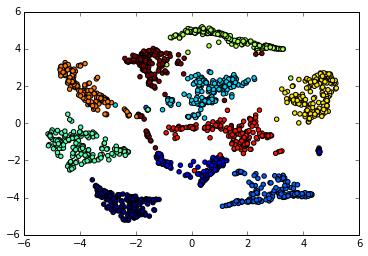

In [163]:
# tSNE = TSNE(learning_rate=100,  n_iter=200).fit_transform(data.data)
scatter(tSNE[:, 0], tSNE[:, 1], c=data.target)

In [173]:
from scipy import stats

class TSNE2():
    def __init__(self, n_components=2, perplexity=30.0, learning_rate=1000.0, n_iter=1000, alpha=0):
        self.perplexity = perplexity # entre 5 et 50
        self.eta = learning_rate
        self.dim = n_components
        self.n_iter = n_iter
        self.alpha = alpha

    def fit_transform(self,x):
        self.x = x
        n,m = self.x.shape

        # Recherche dichotomique du sigma (entre le max des distances et le min)
        
        # Utiliser la décomposition matriciel pour calculer la norm ||xi-xj||² = <xi-xj; xi-xj> 
        x_norm = np.sum(self.x**2,axis=1).reshape(1, n)
        distancex = x_norm + x_norm.T - 2 * np.dot(self.x,self.x.T)
        
        inf = np.zeros((n,1))
        sup = np.ones((n,1)) * np.max(distancex)
        self.sigma = (inf+sup)/2.0
        
        self.lperp = np.log2(self.perplexity)


        #dichotomie        
        while True:
            self.pcond = np.exp( -distancex /(2.0*self.sigma**2) )
            self.pcond = self.pcond / (( self.pcond-np.eye(n) ).sum(axis=1) ).reshape( n,1 ) # ne pas compter si k=i,n

            self.H = - np.sum(  self.pcond * np.log2(self.pcond), axis=0 )
            self.perp = 2**self.H
            
            for i in xrange(n):
                if ( self.perp[i] < self.lperp ):
                    inf[i] = self.sigma[i]
                else:
                    sup[i] = self.sigma[i]
            sigma_old = self.sigma
            self.sigma = ((sup + inf) / 2.)
            if np.max(np.abs(sigma_old - self.sigma)) < 1e-5:
               break


        self.pij = (self.pcond+self.pcond.T) / (2.0*n)
        np.fill_diagonal(self.pij, 0)
        
        # init y
        self.y = np.zeros( (self.n_iter+2,n,self.dim) )
        self.y[1] =  numpy.random.normal(0, 1e-4, (n, self.dim))#1

        loss = []
        for t in xrange( 1, self.n_iter + 1 ):
            # qij
            y_norm = np.sum(self.y[t]**2,axis=1).reshape(1, n)
            distance_y = y_norm + y_norm.T - 2 * np.dot(self.y[t],self.y[t].T)
            
            self.qij = 1 / ( 1 + distance_y )
            np.fill_diagonal(self.qij, 0)
            self.qij = self.qij/self.qij.sum()

            yt = self.y[t]
            grad = 4 * ( (self.pij-self.qij) / (1 + distance_y)).reshape(n,n,1)
            for i in range(n):
                grad_i = ( grad[i] * (yt[i] - yt) ).sum(0)
                self.y[t+1][i] = yt[i] - self.eta * grad_i + self.alpha * (yt[i] - self.y[t-1][i])            
            
            l = stats.entropy(self.pij, self.qij, 2).mean()
            loss.append(l)
            if (t % 1 == 30):
                print t,l, self.pij.mean(), self.qij.mean(), yt.mean()
        return self.y
       
        
# X_new = TSNE2(n_components=2, perplexity=30.0, learning_rate=1000.0, n_iter=50, alpha=0).fit_transform(data.data)


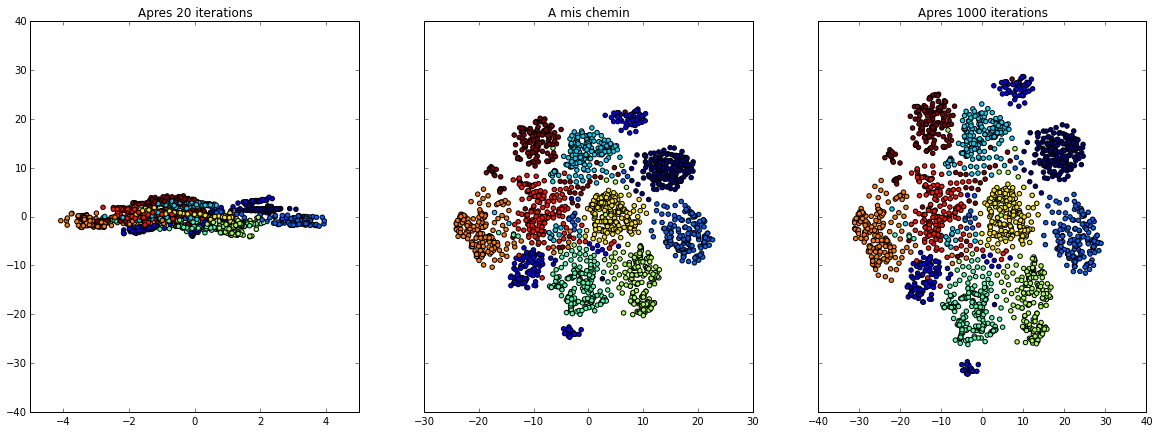

In [79]:
# X_new2 = TSNE3(30,50,1e3,0).fit_transform(data.data)
plt.figure()
f, axarr = plt.subplots(1, 3,figsize=(20, 7), sharey=True)

x_new = np.array(X_new[20])
axarr[0].scatter(x_new[:, 0], x_new[:, 1], c=data.target)
axarr[0].set_title('Apres 20 iterations')

x_new = np.array(X_new[len(X_new) / 2])
axarr[1].scatter(x_new[:, 0], x_new[:, 1], c=data.target)
axarr[1].set_title('A mis chemin')

x_new = np.array(X_new[-1])
axarr[2].scatter(x_new[:, 0], x_new[:, 1], c=data.target)
axarr[2].set_title('Apres ' + str(len(X_new) - 2) + ' iterations')


# Visualisation des données MovieLens

Dans le modèle que nous avons vue précédement, la matrice des ratings $X(N\times M)$ est factorisé en matrice utilisateurs et en matrice items ou chaque utilisateur ( ou item ) est représenté en $F$ valeurs.

Nous allons utiliser notre algorithme tSNE pour projeter nos données utilisateurs ( et items ) sur un espace à 2 dimensions afin de pouvoir le visualiser.

## Utiliser la représentation avec k = 5

In [113]:
def loadMovieLens(path='/data/movielens'):
    # Get movie titles
    movies={}
    for line in open(path+'/u.item'):
        (id,title)=line.split('|')[0:2]
        movies[id]=title
    # Load data
    prefs={}
    for line in open(path+'/u.data'):
        (user,movieid,rating,ts)=line.split('\t')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
    return prefs


In [174]:
# Charement du modèle entrainé
f = open("model.pkl")
model = pkl.load(f)
f.close()

movielens = user_indexed(read_lines(datapath+filename))

x_movies = []
x_users= []
y = []
for (movie_id, rep_movie), (user_id, rep_user) in zip( model.q.items(), model.p.items() ):
    y.append( int(round( model.predict( [ [user_id,movie_id, 0] ] )[0] )) )
    x_movies.append( rep_movie.squeeze() )
    x_users.append( rep_user.squeeze() )

# tSNE_movies = TSNE(learning_rate=1000,  n_iter=200).fit_transform(x_movies)
# tSNE_users = TSNE(learning_rate=100,  n_iter=200).fit_transform(x_users)


tSNE_movies = TSNE2(n_components=2, perplexity=30.0, learning_rate=1000.0, n_iter=200, alpha=0).fit_transform(np.array(x_movies))



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in multiply


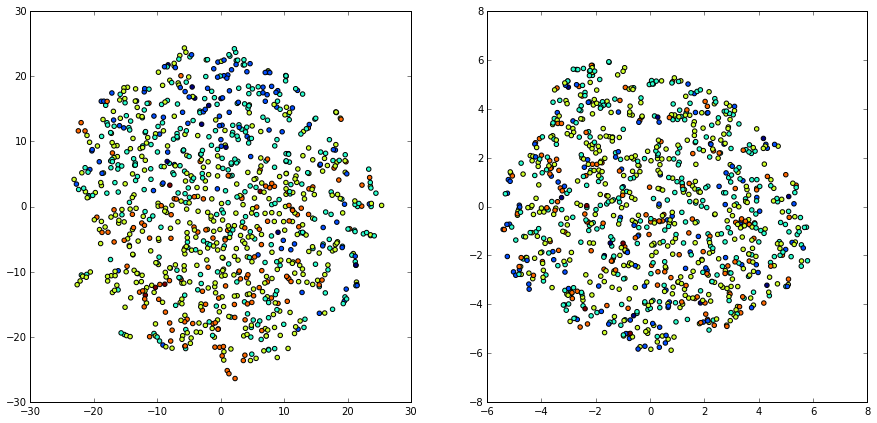

In [181]:
fig = plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.scatter(tSNE_movies[-1][:, 0], tSNE_movies[-1][:, 1], c=y)
plt.subplot(1,2,2)
plt.scatter(tSNE_users[:, 0], tSNE_users[:, 1], c=y)

Avec une représentation des films et des utilisateurs sur 5 valeurs, on n'obtiens pas vraiment de structures particulière après l'application de l'algorithme tSNE. nous allons essayer de représenter les vecteurs users et items sur 50 valeurs.

## Utiliser la représentation avec k = 50

In [189]:
nb_iter = 1000
lmbda = 0.05
k = 50

model = MatrixFactorization(k, iter=nb_iter, lmbda=lmbda, e=1e-3)
model.fit(train_lines)
model.predict(test_lines)
error = model.error(np.array(test_lines, float)[:,2])
print "k: %d,lambda: %.2f, erreur²: %.2f" % (k, lmbda, error)
     
f = open('model_50.pkl', 'w')
pkl.dump(model, f)
f.close()

0: loss=25.20, Temps restant 330.10s
50: loss=0.76, Temps restant 259.56s
100: loss=0.61, Temps restant 256.03s
150: loss=0.51, Temps restant 250.22s
200: loss=0.45, Temps restant 232.58s
250: loss=0.41, Temps restant 216.94s
300: loss=0.38, Temps restant 204.78s
350: loss=0.36, Temps restant 191.94s
400: loss=0.34, Temps restant 179.89s
450: loss=0.33, Temps restant 166.65s
500: loss=0.31, Temps restant 151.44s
550: loss=0.31, Temps restant 136.26s
600: loss=0.30, Temps restant 120.36s
650: loss=0.30, Temps restant 104.66s
700: loss=0.29, Temps restant 89.10s
750: loss=0.29, Temps restant 73.75s
800: loss=0.28, Temps restant 59.37s
850: loss=0.28, Temps restant 44.47s
900: loss=0.28, Temps restant 29.54s
950: loss=0.28, Temps restant 14.54s
k: 50,lambda: 0.05, erreur²: 0.91


In [193]:

movielens = user_indexed(read_lines(datapath+filename))

x_movies = []
x_users= []
y = []
for (movie_id, rep_movie), (user_id, rep_user) in zip( model.q.items(), model.p.items() ):
    y.append( int(round( model.predict( [ [user_id,movie_id, 0] ] )[0] )) )
    x_movies.append( rep_movie.squeeze() )
    x_users.append( rep_user.squeeze() )

# tSNE_movies = TSNE(learning_rate=1000,  n_iter=200).fit_transform(x_movies)
# tSNE_users = TSNE(learning_rate=100,  n_iter=200).fit_transform(x_users)


tSNE_movies = TSNE2(n_components=2, perplexity=30.0, learning_rate=1000.0, n_iter=200, alpha=0).fit_transform(np.array(x_movies))
tSNE_users = TSNE2(n_components=2, perplexity=30.0, learning_rate=1000.0, n_iter=200, alpha=0).fit_transform(np.array(x_users))



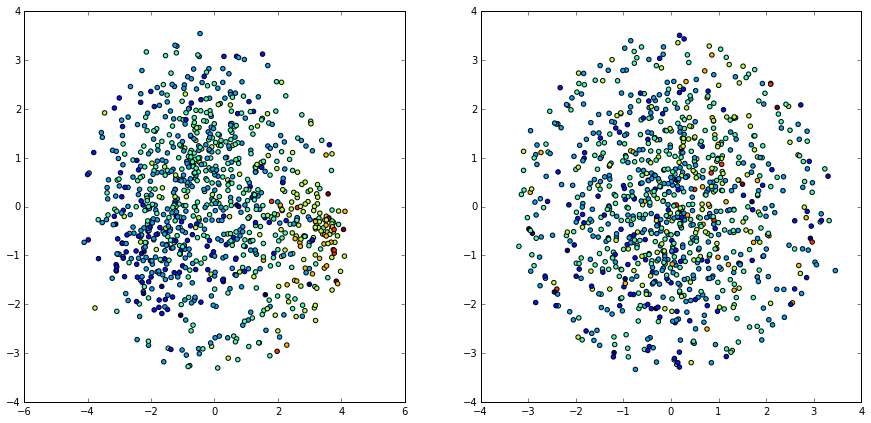

In [194]:


fig = plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.scatter(tSNE_movies[-1][:, 0], tSNE_movies[-1][:, 1], c=y)
plt.subplot(1,2,2)
plt.scatter(tSNE_users[-1][:, 0], tSNE_users[-1][:, 1], c=y)


Avec $k=50$ on commence déja a obtenir quelques structures avec l'algorithme tSNE.

Dans le graphe a gauche, on vois que les films biens classé se retrouve plus ou moins sur la droite du graphe ( points oranges et rouges ) alors que les filmes mal classé sont plutôt à gauche.


## Utiliser la représentation avec k = 150

In [195]:
nb_iter = 200
lmbda = 0.05
k = 150

model = MatrixFactorization(k, iter=nb_iter, lmbda=lmbda, e=1e-3)
model.fit(train_lines)
model.predict(test_lines)
error = model.error(np.array(test_lines, float)[:,2])
print "k: %d,lambda: %.2f, erreur²: %.2f" % (k, lmbda, error)
     
f = open('model_150.pkl', 'w')
pkl.dump(model, f)
f.close()

0: loss=127.49, Temps restant 59.24s
50: loss=0.48, Temps restant 34.90s
100: loss=0.35, Temps restant 25.27s
150: loss=0.30, Temps restant 13.01s
k: 150,lambda: 0.05, erreur²: 1.37


In [196]:

movielens = user_indexed(read_lines(datapath+filename))

x_movies = []
x_users= []
y = []
for (movie_id, rep_movie), (user_id, rep_user) in zip( model.q.items(), model.p.items() ):
    y.append( int(round( model.predict( [ [user_id,movie_id, 0] ] )[0] )) )
    x_movies.append( rep_movie.squeeze() )
    x_users.append( rep_user.squeeze() )

# tSNE_movies = TSNE(learning_rate=1000,  n_iter=200).fit_transform(x_movies)
# tSNE_users = TSNE(learning_rate=100,  n_iter=200).fit_transform(x_users)


tSNE_movies = TSNE2(n_components=2, perplexity=30.0, learning_rate=1000.0, n_iter=200, alpha=0).fit_transform(np.array(x_movies))
tSNE_users = TSNE2(n_components=2, perplexity=30.0, learning_rate=1000.0, n_iter=200, alpha=0).fit_transform(np.array(x_users))



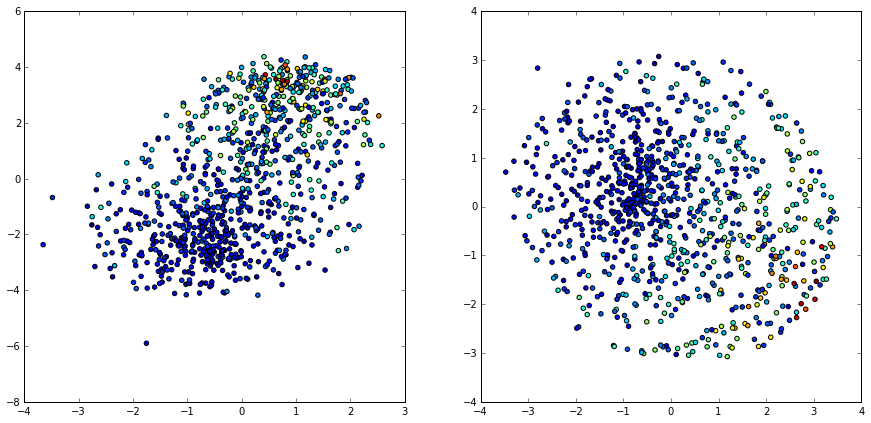

In [197]:
fig = plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.scatter(tSNE_movies[-1][:, 0], tSNE_movies[-1][:, 1], c=y)
plt.subplot(1,2,2)
plt.scatter(tSNE_users[-1][:, 0], tSNE_users[-1][:, 1], c=y)


On remarque que cette fois l'algorithme tSNE est relativement efficace pour représenter les items et les utilisateurs puisqu'on peu faire une séparation visuel de ces points. que ce soit dans la représentation des items à gauche ou dans celle des utilisateurs à droite, il y a une catégorisation qui se fait, c'est a dire des films mal/bien notés si l'on regarde le graphe à gauche, et des utilisateurs qui note mal/bien si l'on regarde le graphe a droite. 

# Conclusion
Dans le Tme 4 nous avions utilisé la factorisation matriciel pour essayer de faire de la recommandation et de remplir une matrice de ratings. cette technique est relativement efficace selon la taille de la représentation choisis pour chaque utilisateur et pour chaque item.

Grace à l'algorithme tSNE, nous avions réussit a réduire cette représentation des utilisateur depuis $k$ dimensions vers $2$ dimensions de sorte à pouvoir les représenter dans un plot.

On a réussit a faire une séparation visuel de ces points grace a tSNE qui est relativement efficace selon la dimensions des données de départ.   